# Check su modello creato

In [1]:
#Per prima cosa importiamo tutto ciò di cui abbiamo bisogno
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import keras.backend
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import SGD
from numpy.random import seed
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score
import copy
import matplotlib.pyplot as plt
import theano.tensor as T
import seaborn as sns
from bioinformatics_helpers.utils import interpolated_precision_recall_curve as pr_curve

/home/alessio/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
base_data_folder = "/home/alessio/dati/"
train_set_filename = base_data_folder + "Mendelian.train.tsv"
test_set_filename = base_data_folder + "Mendelian.test.tsv"

train_X = pd.read_csv(train_set_filename, sep='\t').values
test_X = pd.read_csv(test_set_filename, sep='\t').values
#creiamo le label, nel train set i primi 356 esempi sono positivi, nel test i primi 40 sono positivi
n_positives = 356
n_negatives = train_X.shape[0] - n_positives
train_y = np.concatenate((
    np.ones(n_positives, dtype=np.int32),
    np.zeros(n_negatives, dtype=np.int32)
))
n_positives = 40
n_negatives = test_X.shape[0] - n_positives
test_y = np.concatenate((
    np.ones(n_positives, dtype=np.int32),
    np.zeros(n_negatives, dtype=np.int32)
))
feature_per_example=26
batch_size = 500
my_seed = 2024 #imposto un valore di seed da dare a tutti i generatori
seed(my_seed) #seed numpy

In [3]:
def hingesig(y_true, y_pred):
    transform_y_true = T.switch(T.eq(y_true,0), -1, y_true)
    clipped_y_pred = T.clip(y_pred, 1e-20, 0.9999999)
    logit = (T.log2(clipped_y_pred) - T.log2(T.sub(1., clipped_y_pred)))
    return T.mean(T.maximum(1. - transform_y_true * logit, 0.), axis=-1)

def create_model(loss='binary_crossentropy', activation='tanh'):
    model = Sequential()
    initializer = keras.initializers.glorot_uniform(seed=my_seed)
    model.add(Dense(
            300, 
            input_dim=feature_per_example, 
            kernel_initializer=initializer,
            activation=activation)
             )
    model.add(Dense(
            1,
            kernel_initializer=initializer,
            activation='sigmoid'
    ))
    optimizer = SGD(lr=0.01, decay=0, momentum=0, nesterov=False)
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [10]:
wrapped_model_hinge_sig = KerasClassifier(build_fn=create_model,
                                         batch_size=500,
                                         epochs=10, verbose=1,
                                         shuffle=True,
                                         activation="sigmoid",
                                         loss=hingesig)
wrapped_model_hinge_sig.fit(x=train_X, y=train_y)
wrapped_model_hinge_sig_probas = wrapped_model_hinge_sig.predict_proba(test_X)[:,1]

Epoch 1/10
981388/981388 [==============================] - 36s 36us/step - loss: 0.0011
Epoch 2/10
981388/981388 [==============================] - 36s 36us/step - loss: 8.5841e-04
Epoch 3/10
981388/981388 [==============================] - 36s 36us/step - loss: 8.2480e-04
Epoch 4/10
981388/981388 [==============================] - 36s 37us/step - loss: 8.1529e-04
Epoch 5/10
981388/981388 [==============================] - 36s 37us/step - loss: 8.1042e-04
Epoch 6/10
981388/981388 [==============================] - 36s 37us/step - loss: 8.0395e-04
Epoch 7/10
981388/981388 [==============================] - 36s 37us/step - loss: 7.9659e-04
Epoch 8/10
981388/981388 [==============================] - 36s 37us/step - loss: 7.9038e-04
Epoch 9/10
981388/981388 [==============================] - 36s 37us/step - loss: 7.8296e-04
Epoch 10/10
19018/19018 [==============================] - 0s 19us/step


AUPRC:  0.008536906954062905
AUROC:  0.7169248603646327
Avg prec score:  0.012135834050843206
first 40 predictions:
[0.25715774 0.2562212  0.22700071 0.22929437 0.22929437 0.22685593
 0.22525312 0.22683215 0.22683215 0.32650474 0.32690433 0.28818867
 0.28025773 0.3574213  0.32443577 0.17689641 0.326829   0.32270852
 0.24209352 0.24263157 0.24263157 0.24263157 0.24209385 0.24292581
 0.2354962  0.2354962  0.2354962  0.23556444 0.23586811 0.23586811
 0.23586811 0.23588149 0.23550032 0.23586811 0.23590288 0.23549736
 0.23556158 0.2360832  0.23586307 0.23618399]


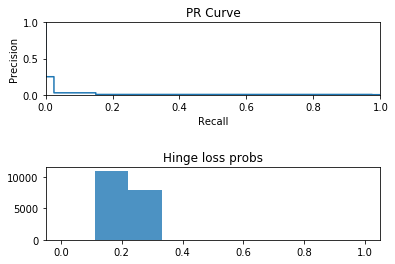

<Figure size 432x288 with 0 Axes>

In [11]:
p,r,t = precision_recall_curve(probas_pred=wrapped_model_hinge_sig_probas, y_true=test_y, pos_label=1)
f, (ax1, ax2) = plt.subplots(2,sharex=False, sharey=False, gridspec_kw={"hspace":1})
r1,p1 = pr_curve(y_prob=wrapped_model_hinge_sig_probas, y_true=test_y)
fig_test = plt.figure()
ax1.axis([0, 1, 0, 1])
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("PR Curve")

ax1.plot(r1,p1)
bins = np.linspace(0,1,10)
ax2.hist(wrapped_model_hinge_sig_probas,bins,alpha=0.8)
ax2.set_title('Hinge loss probs')
print("AUPRC: ", auc(x=r,y=p))
print("AUROC: ", roc_auc_score(y_score=wrapped_model_hinge_sig_probas, y_true=test_y))
print("Avg prec score: ", average_precision_score(y_score=wrapped_model_hinge_sig_probas, y_true=test_y))
print("first 40 predictions:")
print(wrapped_model_hinge_sig_probas[:40])
plt.show()

In [13]:
print("positive class probas mean: {:.2f}, std: {:.2f}"
      .format(
          np.mean(wrapped_model_hinge_sig_probas[:40]),
          np.std(wrapped_model_hinge_sig_probas[:40])
      )
     )

print("negative class probas mean: {:.2f}, std: {:.2f}"
      .format(
          np.mean(wrapped_model_hinge_sig_probas[40:]),
          np.std(wrapped_model_hinge_sig_probas[40:])
      )
     )

df_test_X = pd.read_csv(test_set_filename, sep='\t')
negative_class_test_X = df_test_X.iloc[40:]
data =[best_model_probas[40:],best_model_probas[:40]]
q1_q3 = np.percentile(best_model_probas[:40], [25,75])
iqr = q1_q3[1] - q1_q3[0]
bottom_value = q1_q3[0] - (1.5 * iqr)
high_value = q1_q3[1] + (1.5 * iqr)
#high outliers in negative class


positive class probas mean: 0.25, std: 0.04
negative class probas mean: 0.23, std: 0.04
